# Schweppe et al. - Real Time Search TMT

## Comparing acquisition methods

### Phil Wilmarth, OHSU

### May 25, 2020

## Re-analysis of PXD017823 (human cell lines) 

The PRIDE data was just the human cell line data presented in Figure 4 from the second Real Time Search (RTS) paper by Schweppe, et al. There are HTC116 cells (first 3 channels), MCF7 cells (the next 3 channels), and HEK293 cells (the last 4 channels) labeled with 10-plex TMT. A 180-minute RP LC method for a 12-fraction separation (high pH RP) using the regular SPS MS3 acquisition was compared to running the 12-fractions with a 90-minute SPS MS3 method using real time search (RTS) and protein close-out. Protein close-out is not described in the methods or in citation 4 (it is only described in a figure caption in the first RTS paper). It is (probably) restricting MS3 scans after 4 successful scans have been acquired for a particular protein.

The data from PRIDE was downloaded and processed with my [PAW pipeline](https://github.com/pwilmart/PAW_pipeline):

- Use [MSConvert](http://proteowizard.sourceforge.net/) to make GZipped text files with MS2 and MS3 scans
- Run wide tolerance [Comet](http://comet-ms.sourceforge.net/) searches (simple configuration)
- Compile top-hit PSM summaries (discriminant scores) with reporter ion peak heights
- Accurate mass conditioned target/decoy score histograms to control 1% PSM FDR
- Basic and extended parsimonious protein inference
- Summed reporter ion totals computed for peptides and proteins
- [Internal Reference Scaling (IRS)](https://www.mcponline.org/content/16/5/873) normalization

There are multiple comparisons that can be made. We can compare the same cell line between regular acquisition or RTS acquisition (we would have three comparisons), or we can compare each cell line to the other two cell lines for each acquisition method (regular or RTS). How do we compare the two acquisition methods that were done in two separate TMT experiments? With internal reference scaling (IRS), of course. The samples are the same in each experiment, so this is the very definition of a balanced study design. We will take the average of each 10-channel experiment and use those averages as the proxies for internal reference channels.

#### Protein IDs by Acquisition Method:

Acquisition|Proteins
-----------|--------
Regular SPS MS3 Method|7,361
RTS Method|7,507
Union of results|7,964
Intersection of results|7,469

The individual protein numbers are based on analyzing each acquisition method separately and using a two peptide per protein rule. The setup for the IRS analysis considers both experiments together. The IRS method applies to the proteins in the intersection of the two experiments. The intersection is 93.8% of the union.

> [First RTS paper](https://pubs.acs.org/doi/10.1021/acs.jproteome.8b00899) Erickson, B.K., Mintseris, J., Schweppe, D.K., Navarrete-Perea, J., Erickson, A.R., Nusinow, D.P., Paulo, J.A. and Gygi, S.P., 2019. Active instrument engagement combined with a real-time database search for improved performance of sample multiplexing workflows. Journal of proteome research, 18(3), pp.1299-1306.

> [Second RTS paper](https://pubs.acs.org/doi/10.1021/acs.jproteome.9b00860) Devin K. Schweppe, Jimmy K. Eng, Qing Yu, Derek Bailey, Ramin Rad, Jose Navarrete-Perea, Edward L. Huttlin, Brian K. Erickson, Joao A. Paulo, and Steven P. Gygi, 2020. Full-Featured, Real-Time Database Searching Platform Enables Fast and Accurate Multiplexed Quantitative Proteomics. Journal of proteome research, 19(3), pp.2026−2034.

## Load some R and Bioconductor libraries

In [1]:
library(tidyverse)
library(scales)
library(edgeR)
library(limma)
library(psych)
library(janitor)

# set global plot size (default is 7x7 inch)
options(repr.plot.width=9, repr.plot.height=9)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: limma


Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




### Define functions for use in rest of notebook

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

# =========== Boxplot with median label ========================================
labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

# ================= reformat edgeR test results ================================
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# ============ runs an edgeR exact pairwise test ========================
pairwise_test <- function(delist, pair, p.value) {
    # runs an edgeR exact test and returns results
    et <- exactTest(delist, pair = pair)
    print(summary(decideTestsDGE(et, p.value = p.value)))
    tt <- topTags(et, n = Inf, sort.by = "none")$table
    
    plotMD(et, p.value = p.value)
    abline(h = c(-1, 1), col = "black")
    
    # check the p-value distribution
    pval <- ggplot(tt, aes(PValue)) + 
      geom_histogram(bins = 100, fill = "white", color = "black") + 
      geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
      ggtitle("p-value distribution")
    print(pval) # this makes the plot show up
    
    tt # return top-tags object
}

# ========== Setup for MA and volcano plots ====================================
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

# ========== MA plots using ggplot =============================================
MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== Scatter plots using ggplot ========================================
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Volcano plots using ggplot ========================================
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# ============== individual protein expression plots ===========================
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_candidates <- function(results, nleft, nright, show_these = c("high", "med", "low")) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    
    # get desired candidates
    proteins <- proteins %>% 
        filter(candidate %in% show_these) %>% arrange(candidate)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", p-val: ", scientific(row$FDR, digits = 3), ", ", row$candidate)
        barplot(vec, col = color, main = title)
    } 
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", p-val: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}

## Data is from pandas IRS script

The [PAW pipeline](https://github.com/pwilmart/PAW_pipeline) script for IRS normalization was used with mock reference channels. This has advantages for comparisons because the IRS procedure naturally selects the proteins seen in both experiments. We do not want to get distracted by very ow abundance proteins seen in only a single experiment. We have 7,469 proteins seen in both experiments, after all.  

The resulting tab-delimited file is easy to extract data from for notebook use. We need to get the TMT columns and clean up the names a little. We will drop rows from common contaminants, decoys, and proteins with missing data blocks. 

In [3]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("labeled_grouped_protein_summary_TMT_9_IRS_normalized.txt", guess_max = 8245)

# "Filter" column flags contams and decoys
# "Missing" column flags proteins without reporter ion intensities (full sets missing)
# the table from pandas is sorted so the rows we want come first
data_all <- filter(data_import, is.na(Filter), is.na(Missing))

# get the pooled channels
data_pools <- data_all %>% select(., contains("Pool")) %>%
  select(., contains("Norm_"))

# clean up column names 
data_all <- data_all %>% rename_all(funs(str_replace(., "Norm_", "_"))) %>% 
  rename_all(funs(str_replace(., "RTS_1", "RTS"))) %>% 
  rename_all(funs(str_replace(., "Reg_2", "Reg"))) 

# get the data before and after IRS
# there is no need to check the mock pool channels
data_sl <- select(data_all, contains("SL_"), -contains("Pool"))
data_irs <- select(data_all, contains("IRS_"), -contains("Pool"))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows of data we have
length(accessions)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Description = col_character()
)

See spec(...) for full column specifications.

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”


[1] 7469

### Define column indexes for cell lines

In [4]:
# define some subset names for later
HCT <- c(1:3, 11:13)
MCF <- c(4:6, 14:16)
HEK <- c(7:10, 17:20)

# set up a matching "color" vector
color = c(rep(c(rep("blue", 3), rep("red", 3), rep("green", 4)), 2))

## Check the data before IRS normalization


Sample column sums:
 SL_HCT116_1_RTS -> 5607718028
 SL_HCT116_2_RTS -> 5608461617
 SL_HCT116_3_RTS -> 5606990384
 SL_MCF_1_RTS -> 5611340342
 SL_MCF_2_RTS -> 5610842339
 SL_MCF_3_RTS -> 5611093126
 SL_HEK293_1_RTS -> 5609243074
 SL_HEK293_2_RTS -> 5610936765
 SL_HEK293_3_RTS -> 5607746651
 SL_HEK293_4_RTS -> 5607059315
 SL_HCT116_1_Reg -> 5615357764
 SL_HCT116_2_Reg -> 5616182909
 SL_HCT116_3_Reg -> 5614685201
 SL_MCF_1_Reg -> 5611093968
 SL_MCF_2_Reg -> 5610287497
 SL_MCF_3_Reg -> 5610961851
 SL_HEK293_1_Reg -> 5610410404
 SL_HEK293_2_Reg -> 5611223567
 SL_HEK293_3_Reg -> 5610288531
 SL_HEK293_4_Reg -> 5611099015


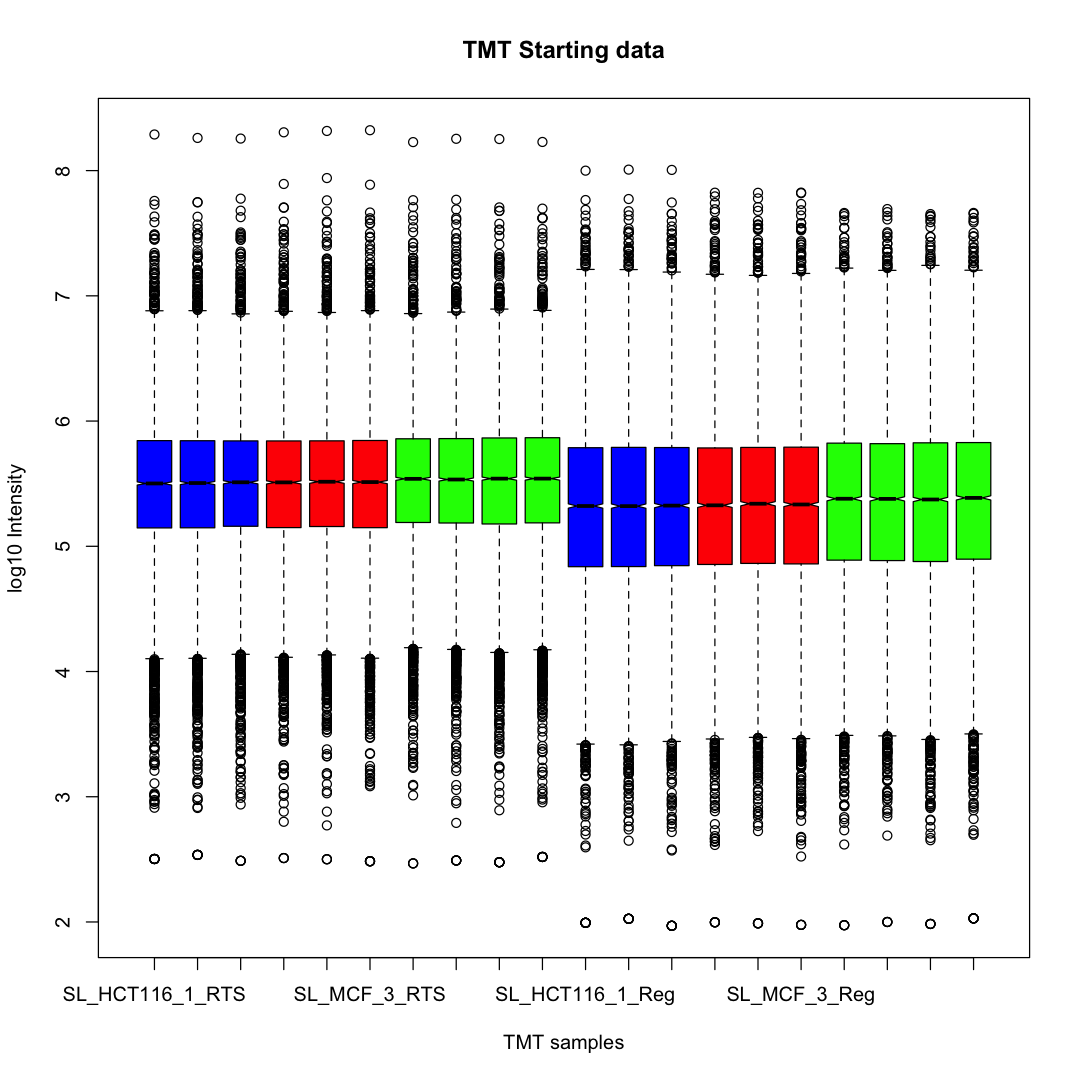

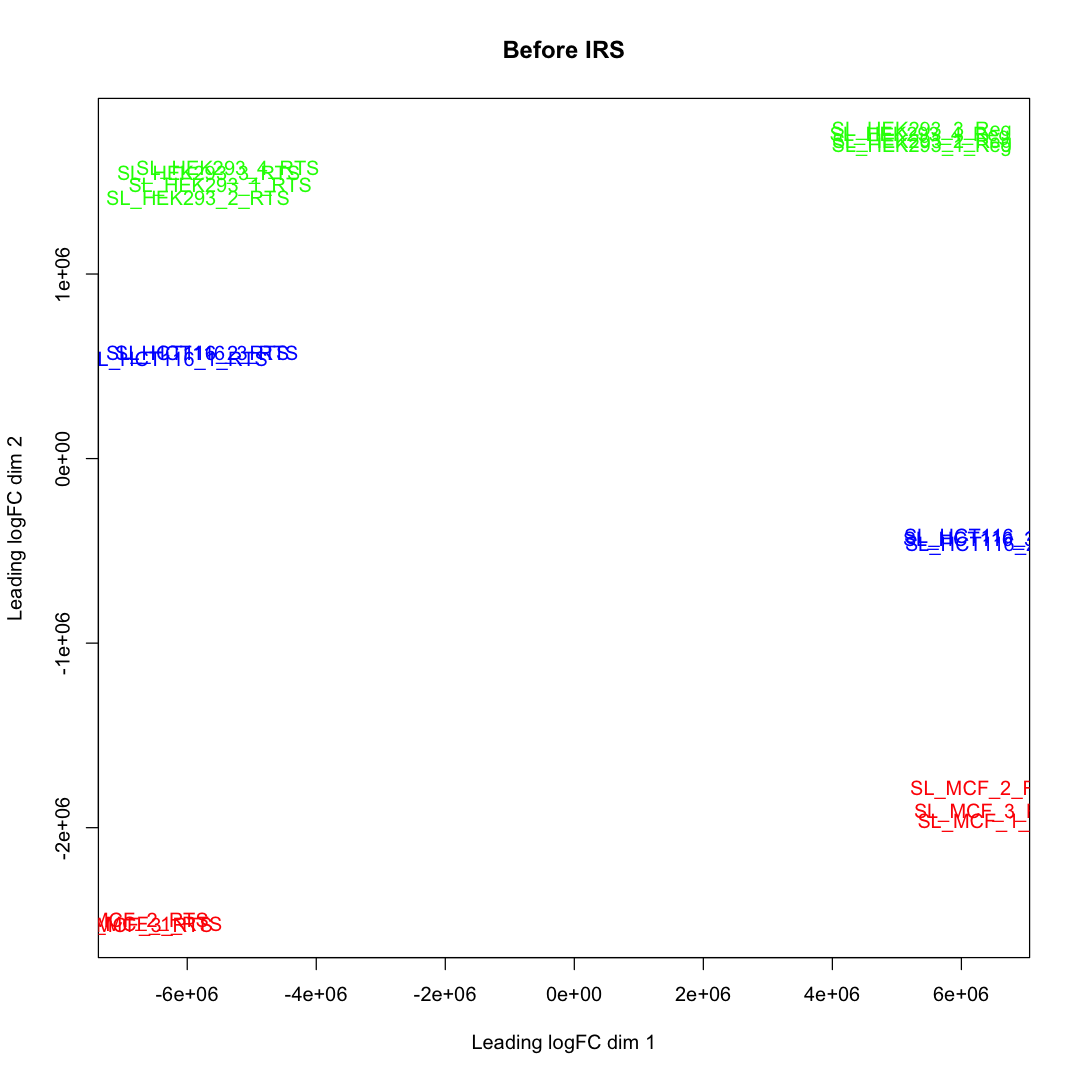

In [5]:
# look at the column sums (they should be roughly equal)
cat("\nSample column sums:\n", sprintf("%-5s -> %0.0f\n", names(data_sl), colSums(data_sl)))

# check the data before normalization with boxplots
boxplot(log10(data_sl), col = color,
        xlab = 'TMT samples', ylab = 'log10 Intensity', 
        main = 'TMT Starting data', notch = TRUE)

# check clustering
plotMDS(data_sl, col = color, main = "Before IRS")

### Samples cluster by TMT plex (left/right) and by cell line (top/bottom)

The column totals are all roughly the same. The IRS script first matches the TMT plexes by column totals within each plex and then matches the sums of each plex to each other. We see clear differences in the distributions of intensities in each plex from the boxplots. We have a TMT plex batch effect, too.

## Check the same things after IRS


IRS sample column sums:
 IRS_HCT116_1_RTS -> 4532513948
 IRS_HCT116_2_RTS -> 4552557744
 IRS_HCT116_3_RTS -> 4556053783
 IRS_MCF_1_RTS -> 4518663519
 IRS_MCF_2_RTS -> 4491093511
 IRS_MCF_3_RTS -> 4507831976
 IRS_HEK293_1_RTS -> 4497065578
 IRS_HEK293_2_RTS -> 4481695024
 IRS_HEK293_3_RTS -> 4502197410
 IRS_HEK293_4_RTS -> 4479969005
 IRS_HCT116_1_Reg -> 4459168673
 IRS_HCT116_2_Reg -> 4463184519
 IRS_HCT116_3_Reg -> 4454870669
 IRS_MCF_1_Reg -> 4425896898
 IRS_MCF_2_Reg -> 4436824454
 IRS_MCF_3_Reg -> 4439515159
 IRS_HEK293_1_Reg -> 4603661406
 IRS_HEK293_2_Reg -> 4608603645
 IRS_HEK293_3_Reg -> 4603662505
 IRS_HEK293_4_Reg -> 4627767385


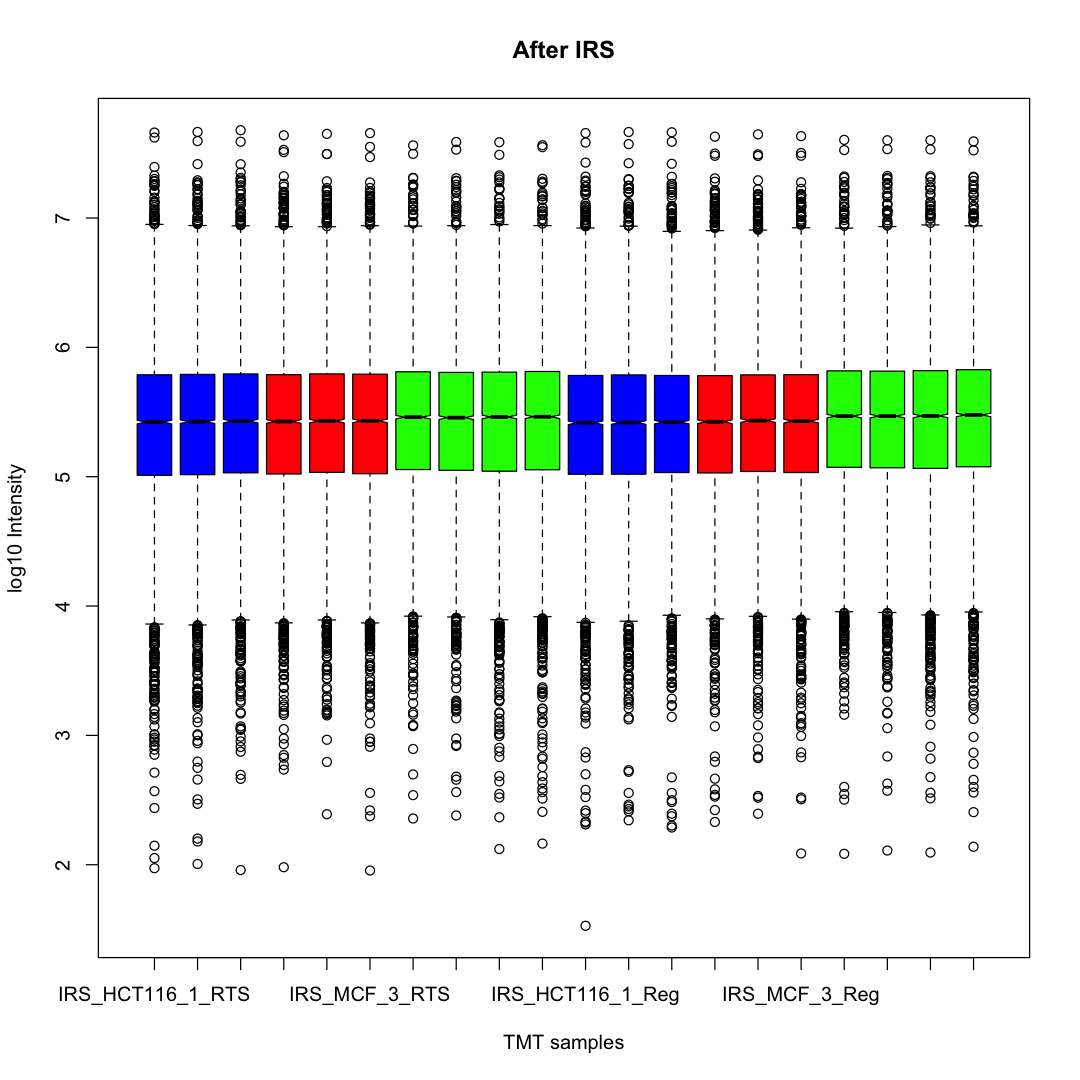

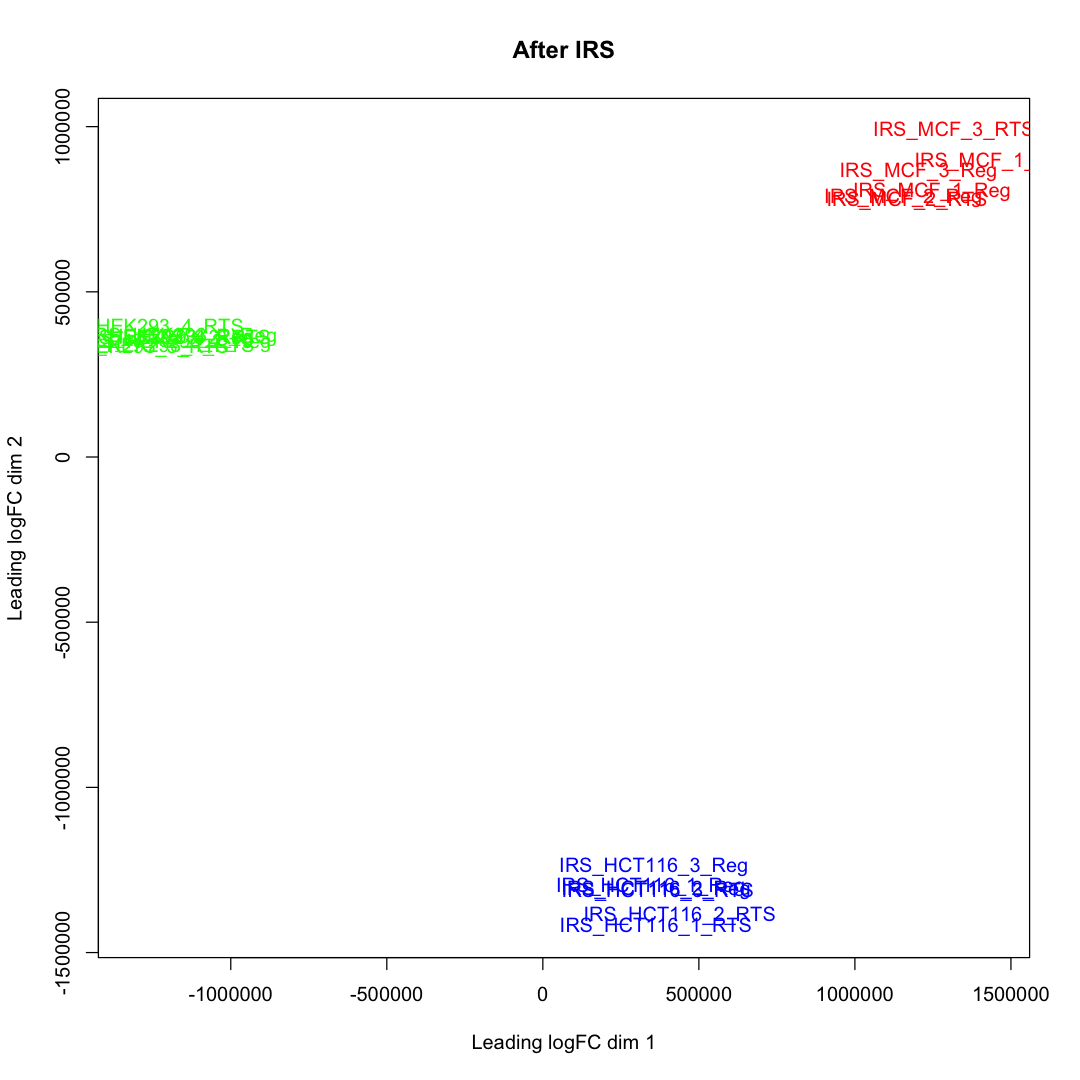

In [6]:
# look at the column sums (they should be roughly equal)
cat("\nIRS sample column sums:\n", 
    sprintf("%-5s -> %0.0f\n", names(data_irs), colSums(data_irs)))

# check the data before normalization
boxplot(log10(data_irs), col = color,
        xlab = 'TMT samples', ylab = 'log10 Intensity', 
        main = 'After IRS', notch = TRUE)

# check clustering
plotMDS(data_irs, col = color, main = "After IRS")

### Samples cluster by cell line after IRS

After IRS, the boxplots from both experiments are similar and in horizontal alignment. The samples all cluster by cell type after IRS. We have 3 clusters. We can also run the trimmed mean of M-values normalization function in edgeR to correct for any compositional differences between samples.

## Compute TMM factors with edgeR and finish normalizing the data

EdgeR does not compute a normalized data table for us. It uses factors in the linear modeling. We can do the normalizations by hand and check the box plots. 


Library size factors:
 IRS_HCT116_1_RTS -> 0.995505
 IRS_HCT116_2_RTS -> 0.991122
 IRS_HCT116_3_RTS -> 0.990361
 IRS_MCF_1_RTS -> 0.998556
 IRS_MCF_2_RTS -> 1.004686
 IRS_MCF_3_RTS -> 1.000956
 IRS_HEK293_1_RTS -> 1.003352
 IRS_HEK293_2_RTS -> 1.006793
 IRS_HEK293_3_RTS -> 1.002208
 IRS_HEK293_4_RTS -> 1.007181
 IRS_HCT116_1_Reg -> 1.011879
 IRS_HCT116_2_Reg -> 1.010969
 IRS_HCT116_3_Reg -> 1.012855
 IRS_MCF_1_Reg -> 1.019486
 IRS_MCF_2_Reg -> 1.016975
 IRS_MCF_3_Reg -> 1.016359
 IRS_HEK293_1_Reg -> 0.980120
 IRS_HEK293_2_Reg -> 0.979069
 IRS_HEK293_3_Reg -> 0.980120
 IRS_HEK293_4_Reg -> 0.975014

Trimmed mean of M-values (TMM) factors:
 IRS_HCT116_1_RTS -> 1.032721
 IRS_HCT116_2_RTS -> 1.034361
 IRS_HCT116_3_RTS -> 1.027198
 IRS_MCF_1_RTS -> 1.072025
 IRS_MCF_2_RTS -> 1.045241
 IRS_MCF_3_RTS -> 1.061933
 IRS_HEK293_1_RTS -> 0.943634
 IRS_HEK293_2_RTS -> 0.951202
 IRS_HEK293_3_RTS -> 0.940686
 IRS_HEK293_4_RTS -> 0.930475
 IRS_HCT116_1_Reg -> 1.023828
 IRS_HCT116_2_Reg -> 1.021141
 IR

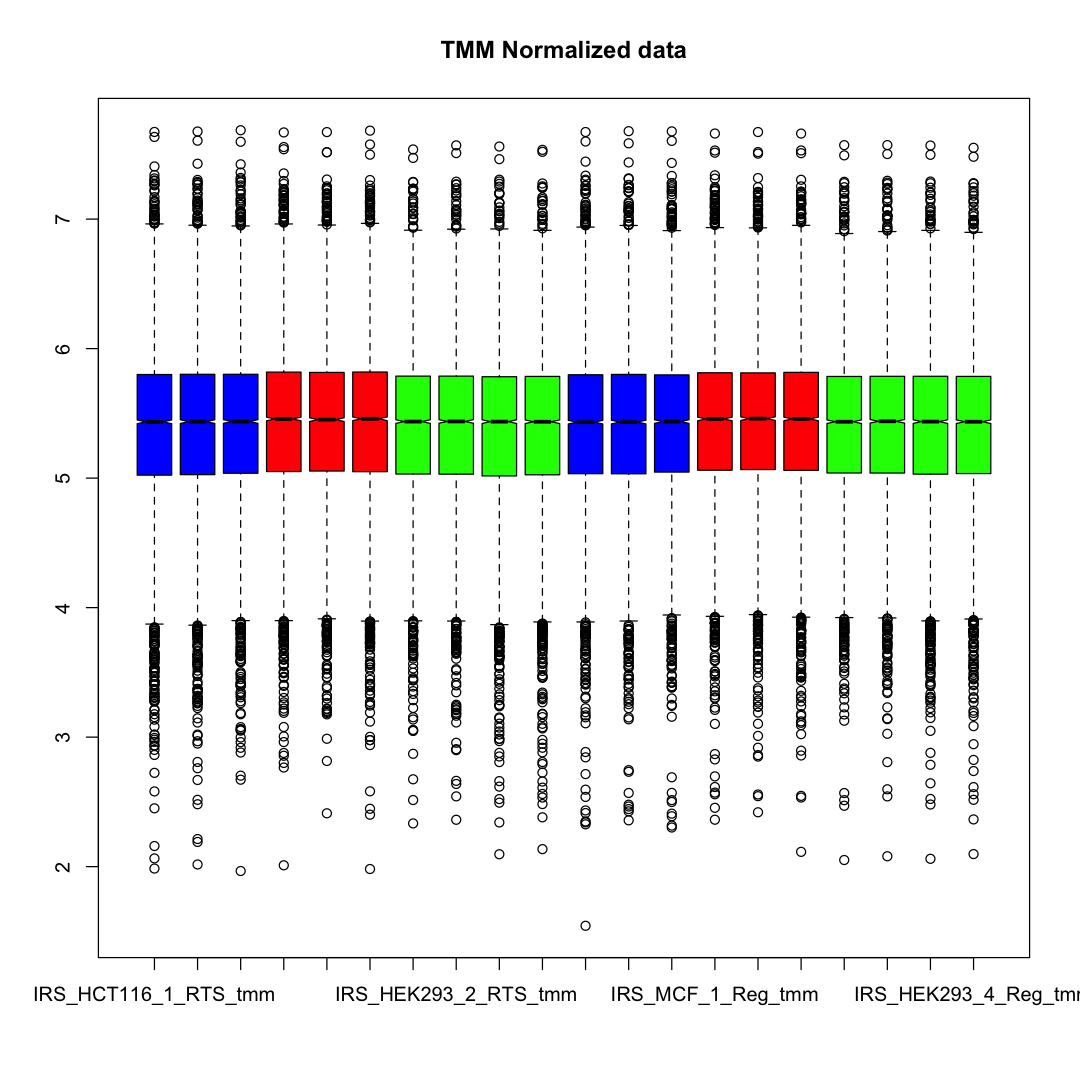

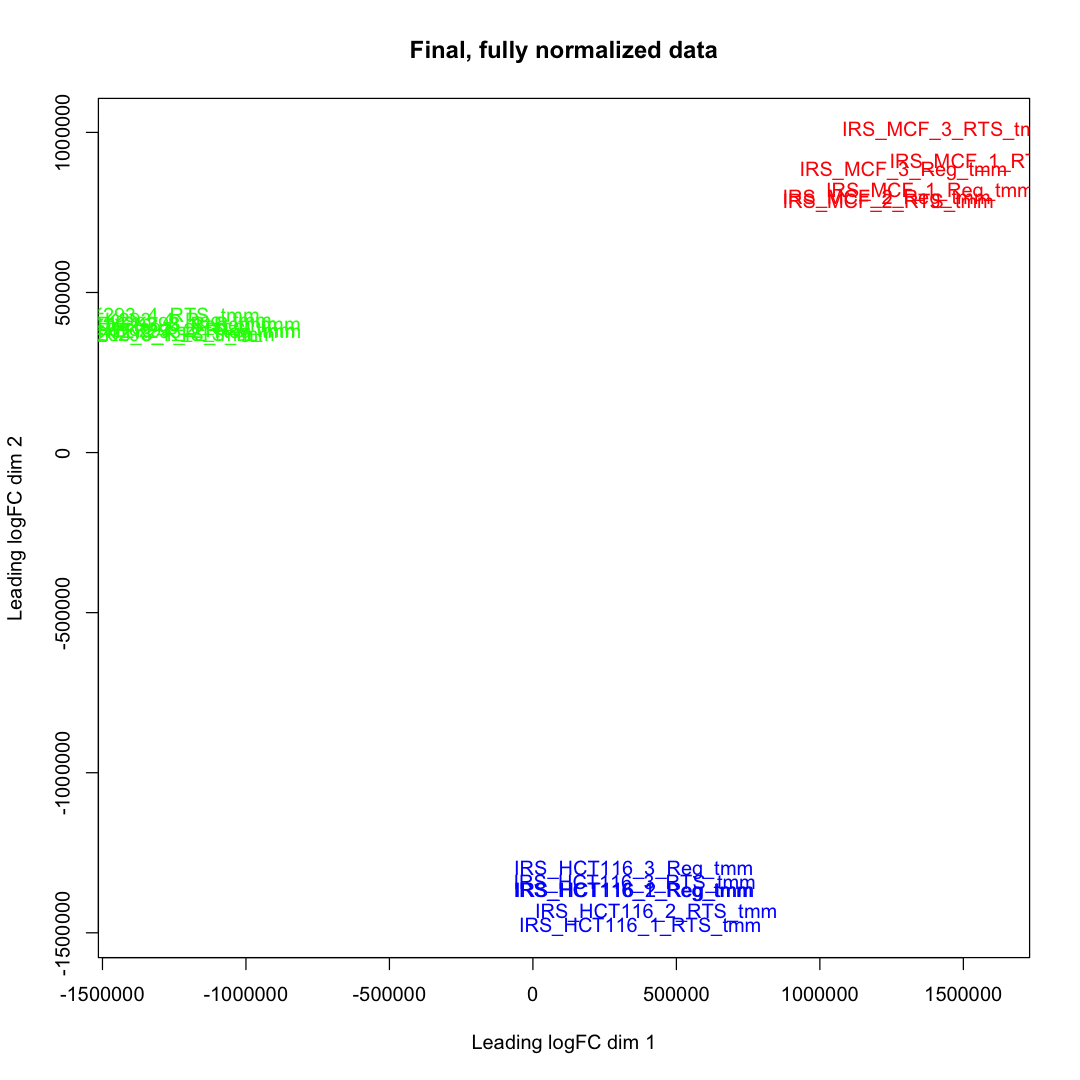

In [7]:
# load data into edgeR objects
group  <- c(rep("HCT_RTS", 3), rep("MCF_RTS", 3), rep("HEK_RTS", 4),
            rep("HCT_Reg", 3), rep("MCF_Reg", 3), rep("HEK_Reg", 4))
y <- DGEList(counts = data_irs, group = group, gene = accessions)

# normalize the data and compute dispersion
y <- calcNormFactors(y)

# compute TMM normalized intensities
tmt_tmm <- apply_tmm_factors(y, color)

# check final clustering
plotMDS(tmt_tmm, col = color, main = "Final, fully normalized data")

### Composition of HCT116 and MCF7 cells were similar

HCT116 and MCF7 cells had similar TMM factors indicating similar composition. The factors for HEK293 were a little less than 1.0 with either acquisition method. The small library size factors are because we have already done a similar normalization as part of the IRS method.

## See what the mock reference channels look like

We know that pseudo random MS2 scan selection increases the variance of the data and that is the reason we have to do IRS in the first place (see [this link](https://pwilmart.github.io/TMT_analysis_examples/IRS_validation.html) for more background on IRS). Let's see what the mock reference channel (the experiment-wide average intensity vector) looks like before and after the IRS method.

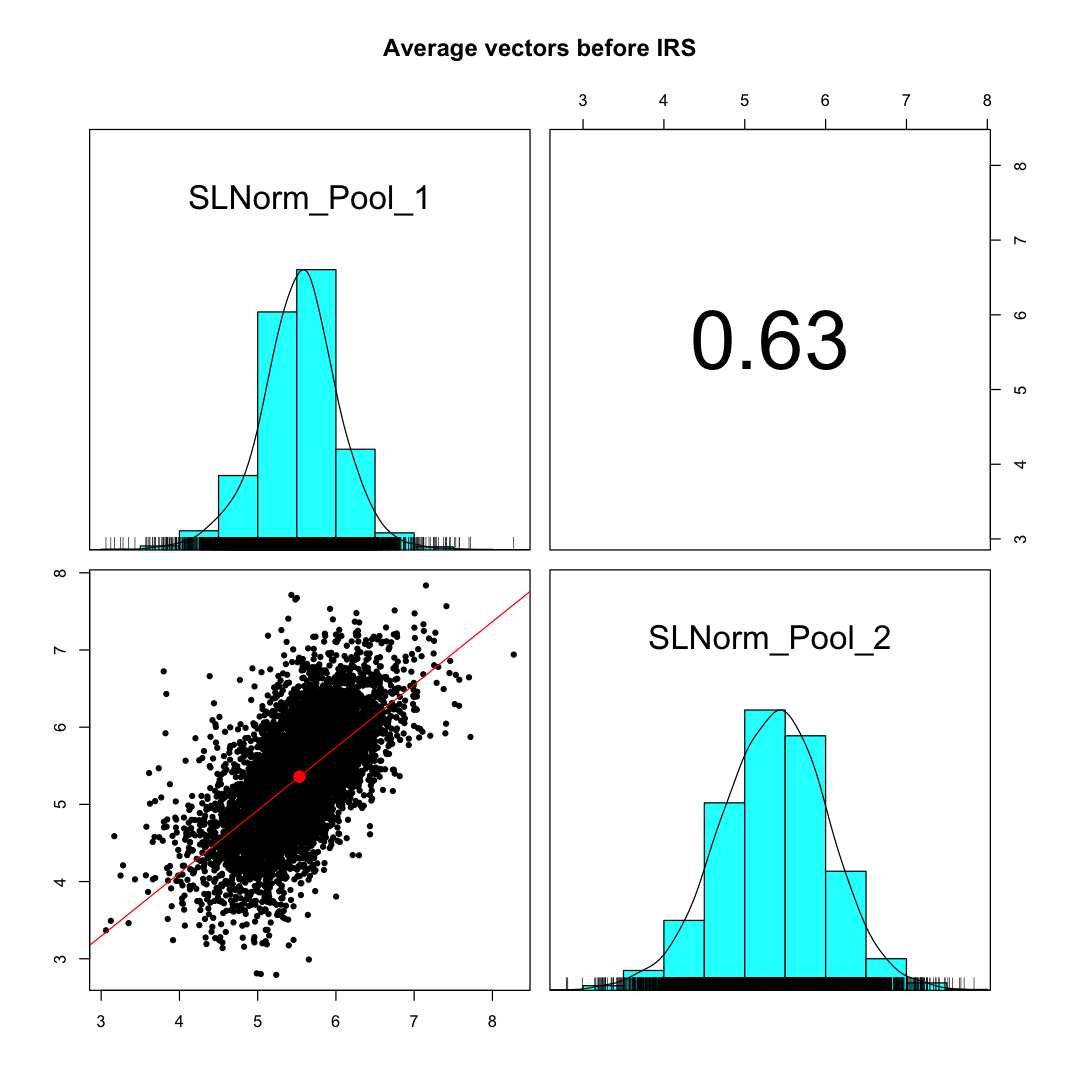

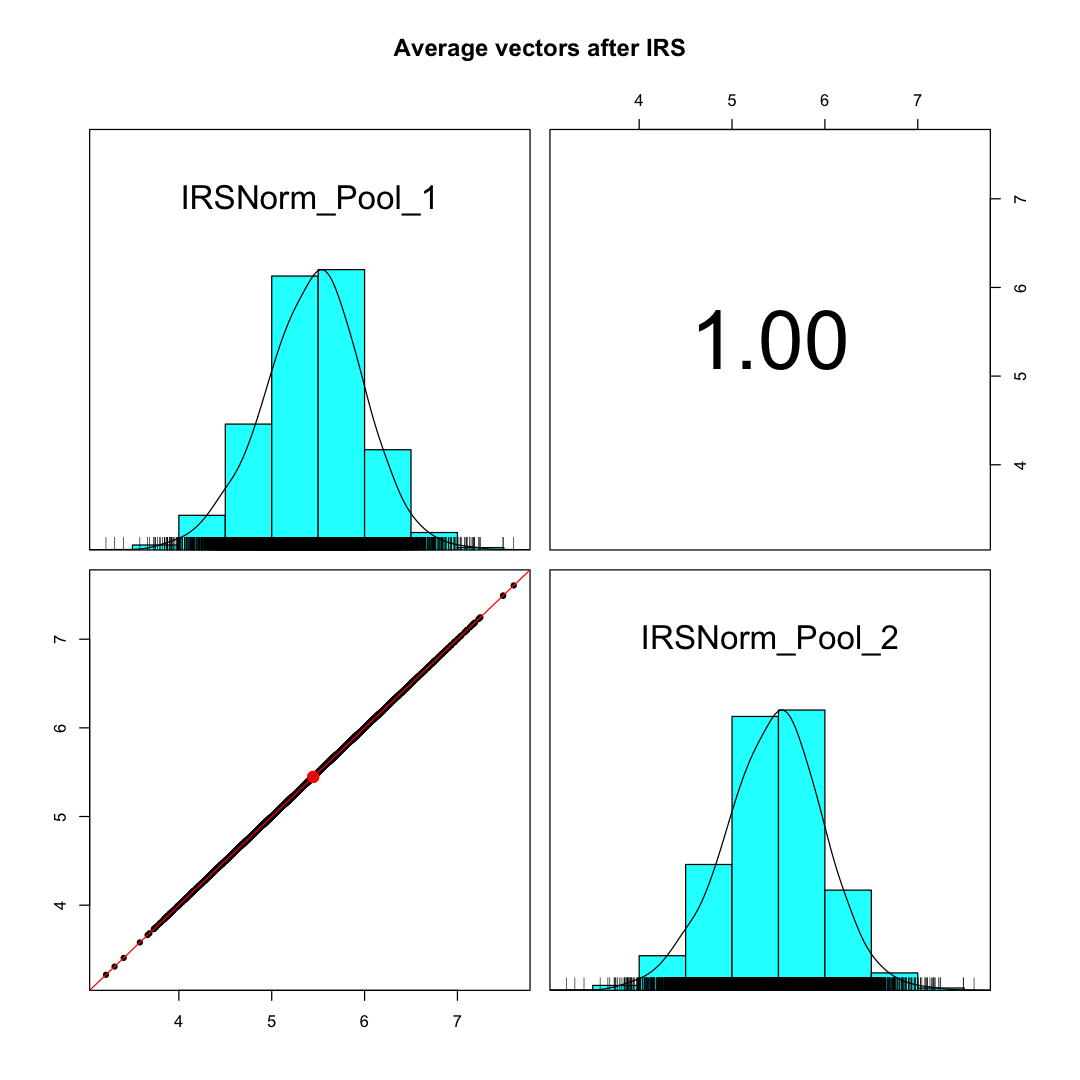

In [8]:
# check the mock reference channels before and after IRS
pairs.panels(log10(data_pools[1:2]), lm = TRUE, main = "Average vectors before IRS")
pairs.panels(log10(data_pools[3:4]), lm = TRUE, main = "Average vectors after IRS")

### The before IRS plot looks really strange

The average intensities for individual proteins are really different in the regular SPS MS3 method and the real time search method before IRS. What is going on? The big difference is the protein close-out logic for the RTS data. This limits the MS3 scans acquired for each protein to a maximum of 4 per LC run. This is a little like the usual dynamic exclusion on modern mass specs to keep them from over-sampling the abundant features. We sample the higher abundance proteins much less in the RTS method. Interestingly, lower abundance proteins may not exceed 4 PSMs per LC run and would be sampled similarly in either method. Note that the limit of 4 PSMs per LC run is not the 4 best PSMs. It is the **first** 4 PSMs. The IRS method seems to handle the unusual starting data and makes the intensities identical after adjustments.

## Compare the same cell lines to each other

We can use some scatter plots to see how similar each biological replicate (of each cell line) was to each other. We can see what affect IRS had.

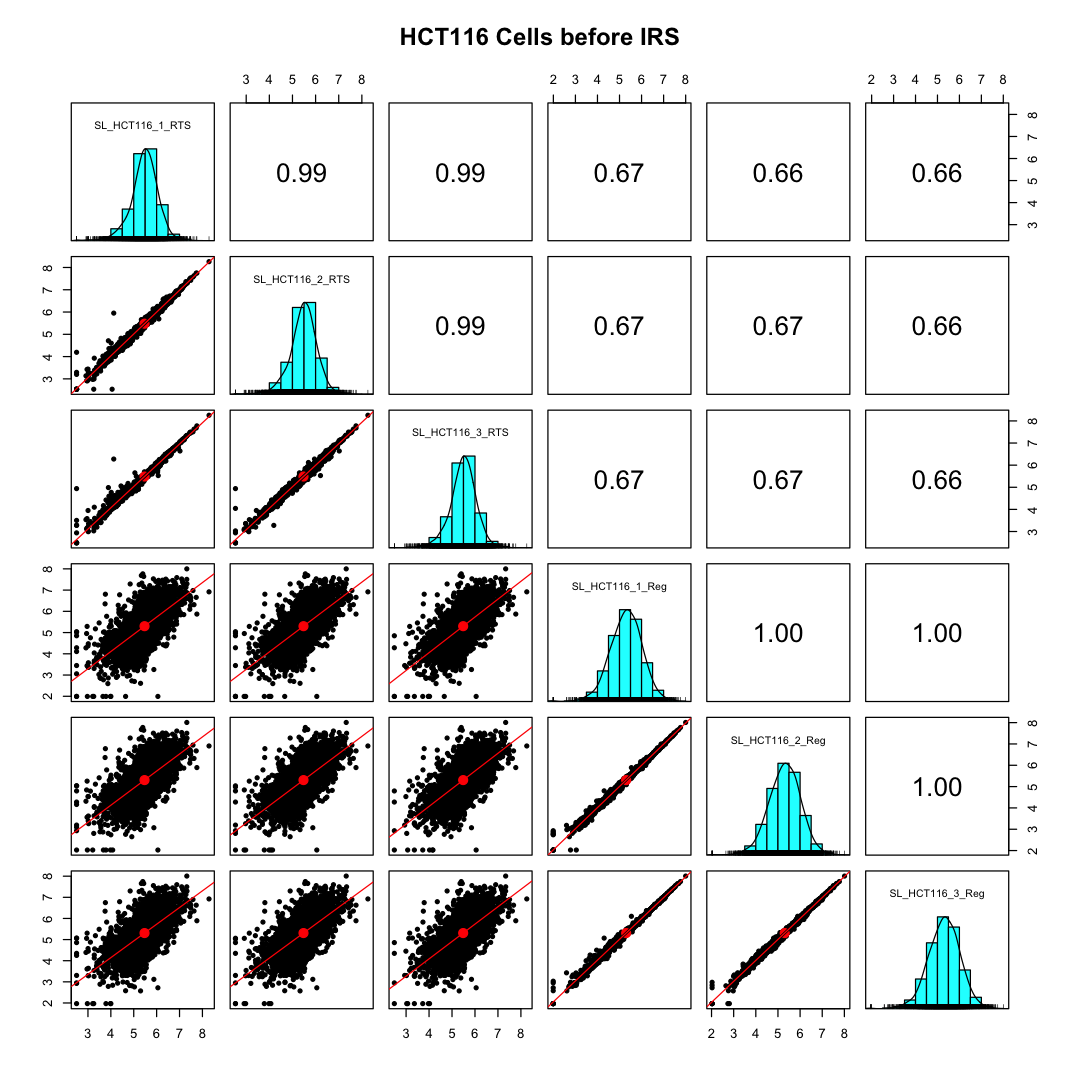

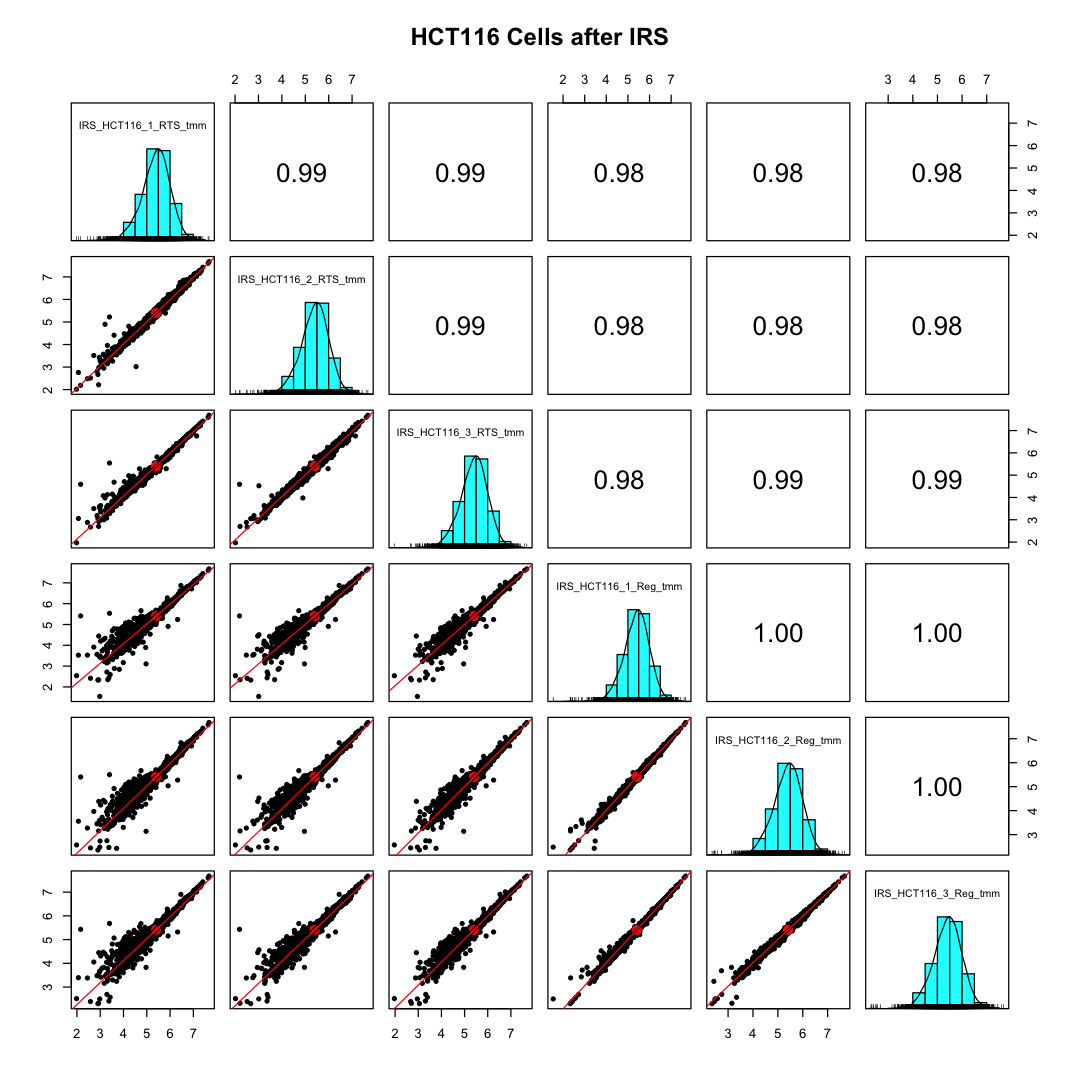

In [9]:
# compare samples in same condition to each other
pairs.panels(log10(data_sl[HCT]), lm = TRUE, main = "HCT116 Cells before IRS")
pairs.panels(log10(tmt_tmm[HCT]), lm = TRUE, main = "HCT116 Cells after IRS")

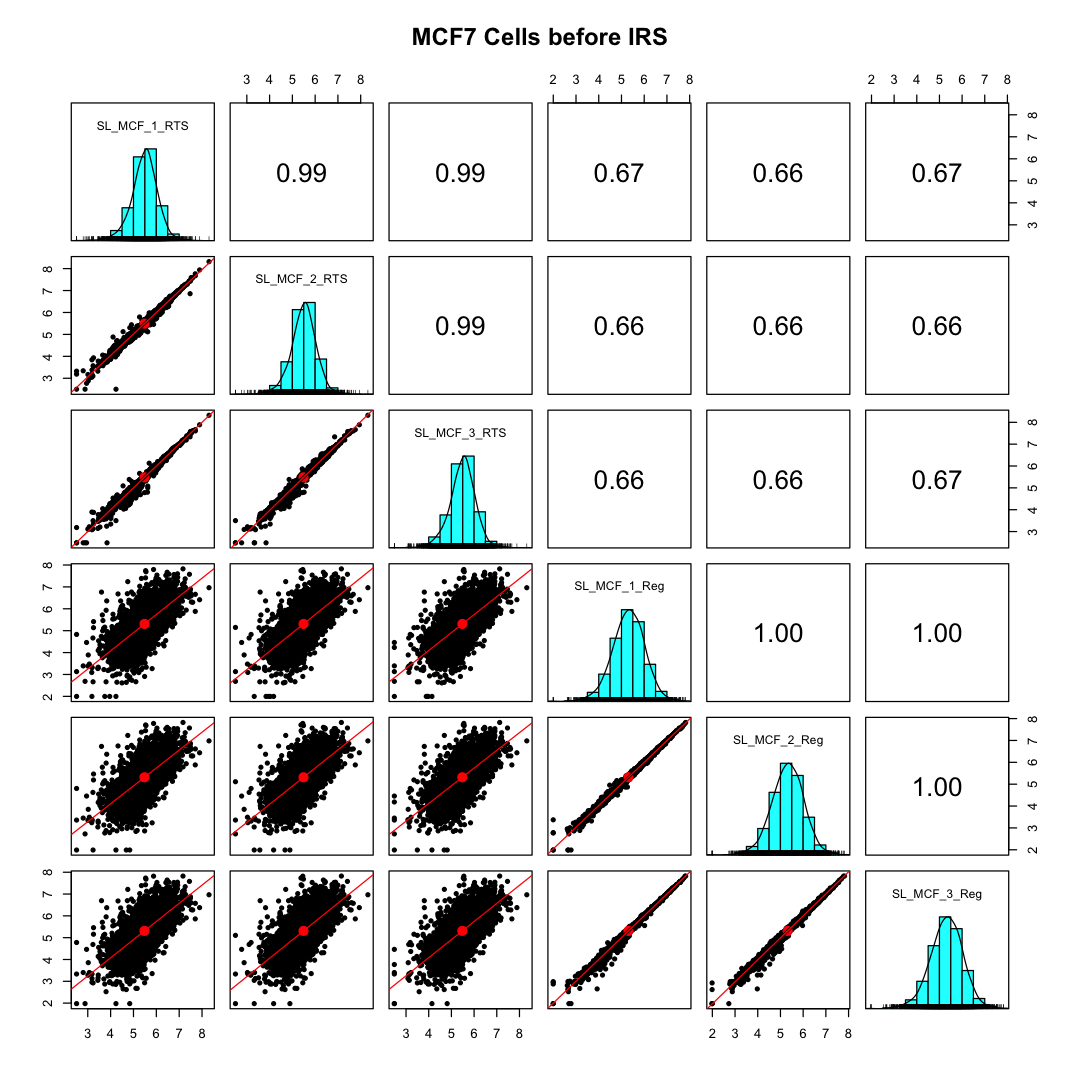

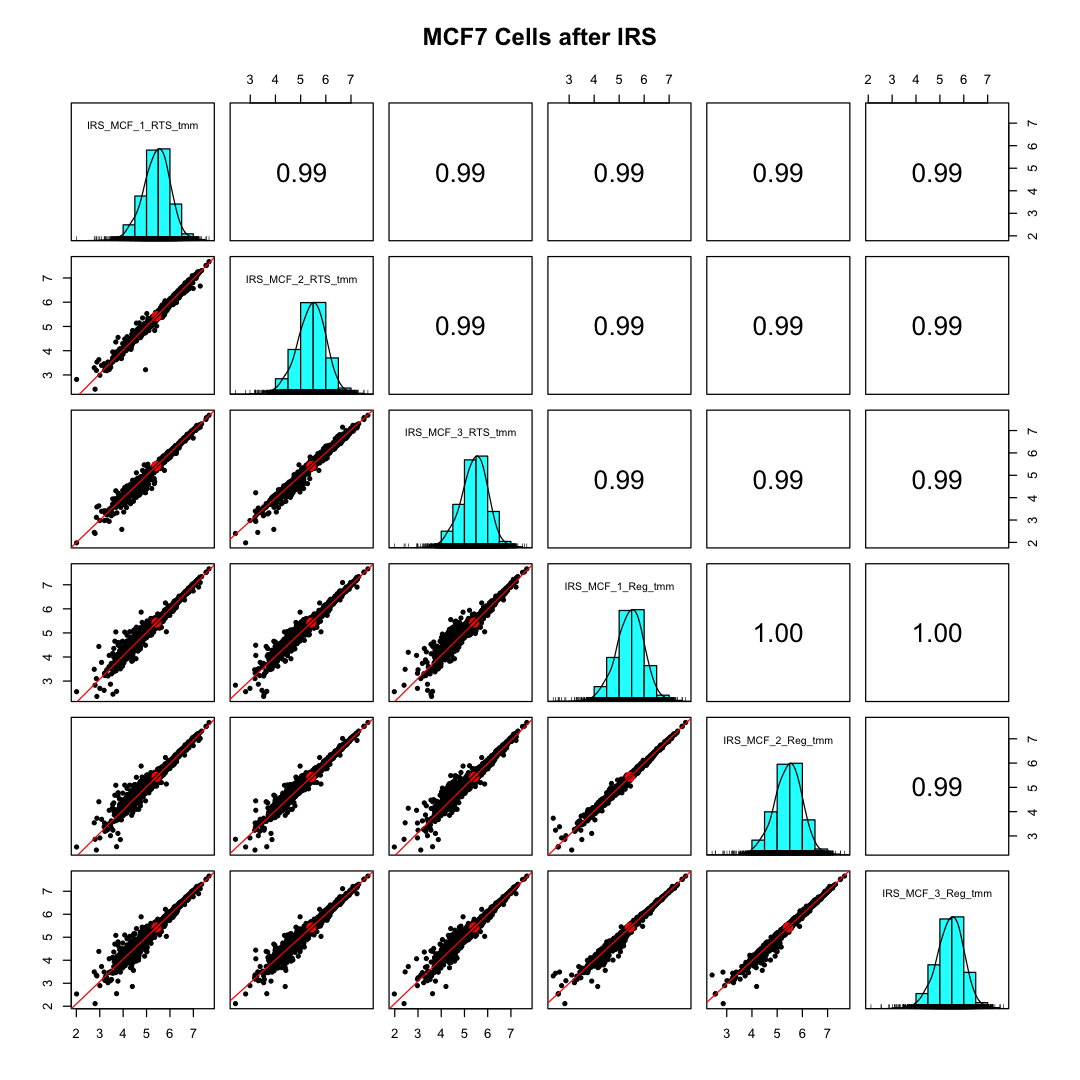

In [10]:
# compare samples in same condition to each other
pairs.panels(log10(data_sl[MCF]), lm = TRUE, main = "MCF7 Cells before IRS")
pairs.panels(log10(tmt_tmm[MCF]), lm = TRUE, main = "MCF7 Cells after IRS")

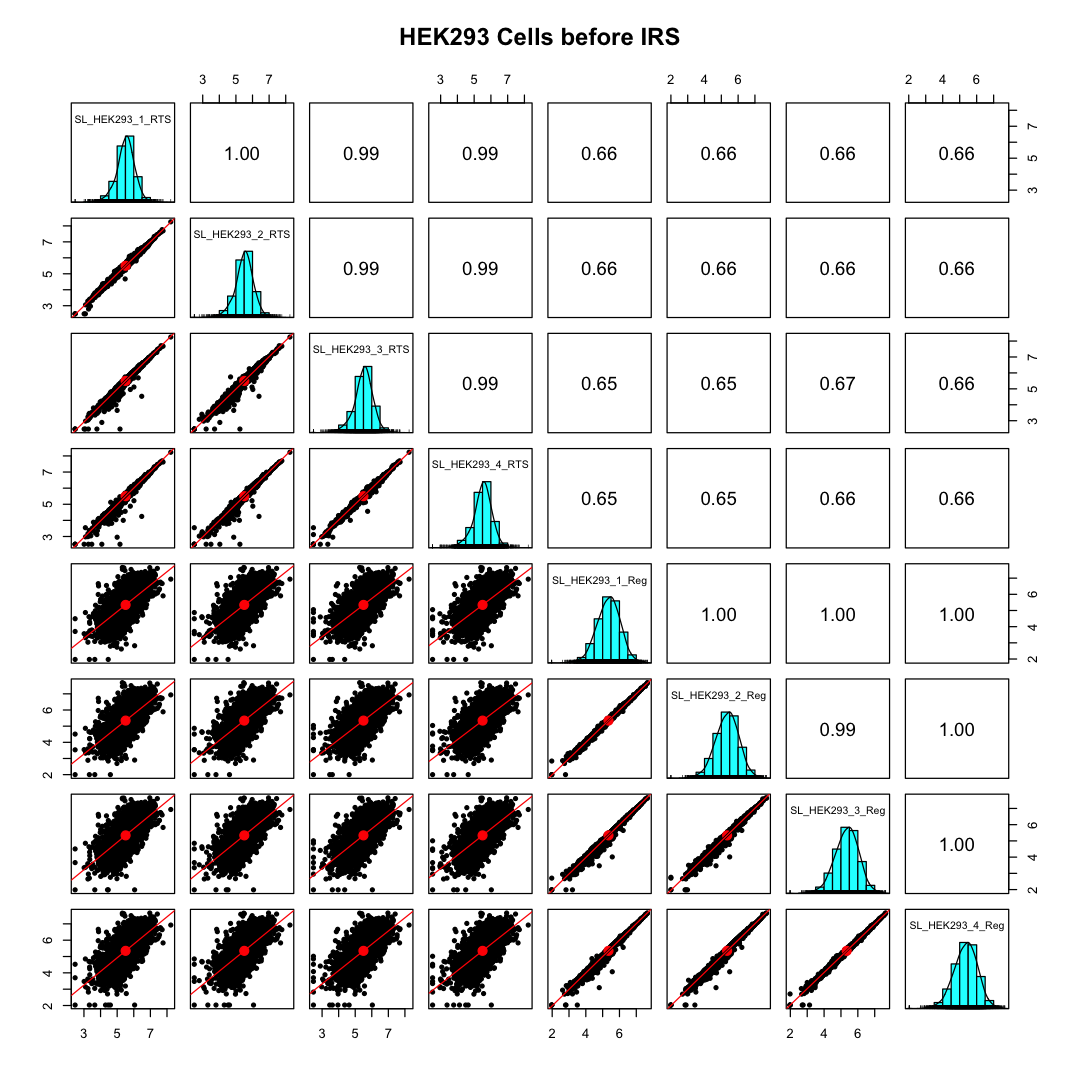

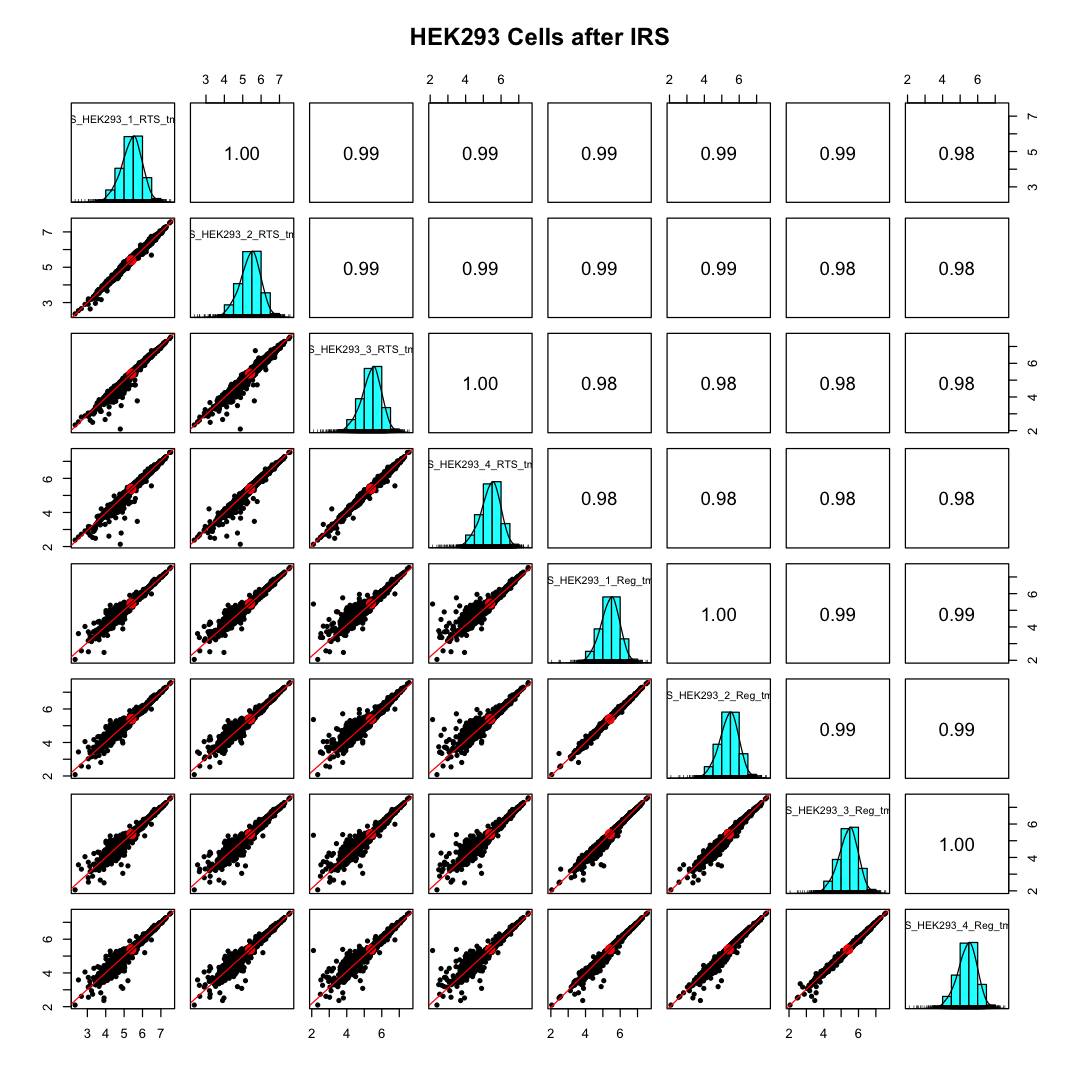

In [11]:
# compare samples in same condition to each other
pairs.panels(log10(data_sl[HEK]), lm = TRUE, main = "HEK293 Cells before IRS")
pairs.panels(log10(tmt_tmm[HEK]), lm = TRUE, main = "HEK293 Cells after IRS")

### IRS correct most of the differences between acquisition methods

We have very similar intensities by biological replicate within each TMT plex (by acquisition mode). This is true either before or after IRS. The between plex replicates are really different before IRS. They are much more similar after IRS; however, they are not as similar as the within plex replicates.

## See what CV distributions look like

### Real Time Search data first

In [12]:
# define some index variables
rts <- 1:10
reg <- 11:20
HCT <- 1:3
MCF <- 4:6
HEK <- 7:10

[1] "TMT CVs (%)"


HCT  MCF  HEK 
5.04 4.69 5.32

Warning message:
“Removed 106 rows containing non-finite values (stat_density).”


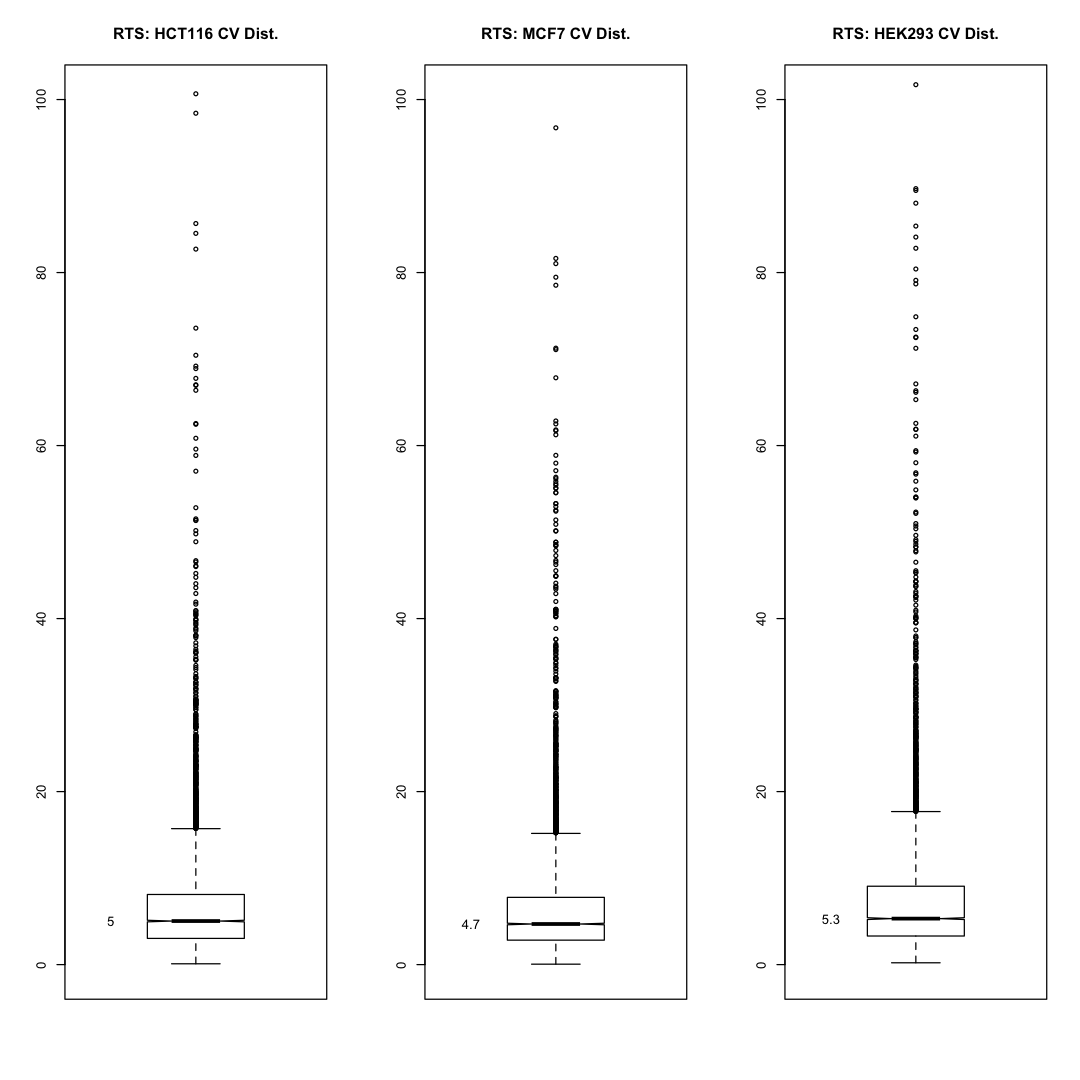

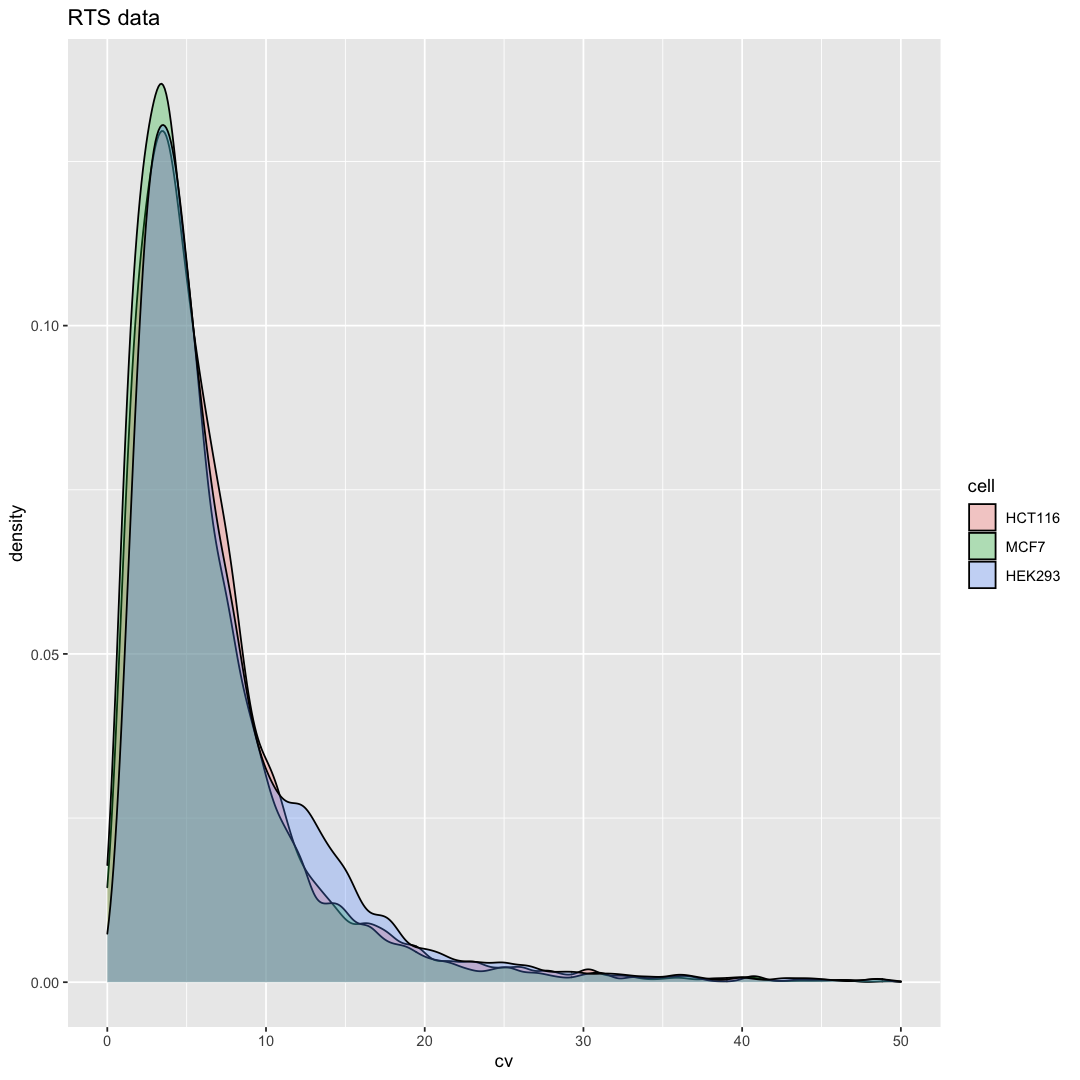

In [13]:
# get the RTS data from the SLNorm data
data_sl_rts <- data_sl[rts]

# print out some CV values
CV_tmt <- data.frame(HCT = CV(data_sl_rts[HCT]), MCF = CV(data_sl_rts[MCF]), 
                  HEK = CV(data_sl_rts[HEK]))
medians <- apply(CV_tmt, 2, FUN = median)
print("TMT CVs (%)")
round(medians, 2)

# labeled boxplots
par(mfrow = c(1, 3))
labeled_boxplot(data_sl_rts[HCT], 100, "RTS: HCT116 CV Dist.")
labeled_boxplot(data_sl_rts[MCF], 100, "RTS: MCF7 CV Dist.")
labeled_boxplot(data_sl_rts[HEK], 100, "RTS: HEK293 CV Dist.")
par(mfrow = c(1, 1))

# CV density plot
cv_long <- rbind(data.frame(cv = CV(data_sl_rts[HCT]), cell = "HCT116"),
                data.frame(cv = CV(data_sl_rts[MCF]), cell = "MCF7"),
                data.frame(cv = CV(data_sl_rts[HEK]), cell = "HEK293"))
ggplot(cv_long, aes(x=cv, fill=cell)) +
  geom_density(alpha=0.3) +
  xlim(0, 50) +
  ggtitle("RTS data")

### Regular SPS MS3 mode

[1] "TMT CVs (%)"


HCT  MCF  HEK 
3.88 4.02 4.41

Warning message:
“Removed 76 rows containing non-finite values (stat_density).”


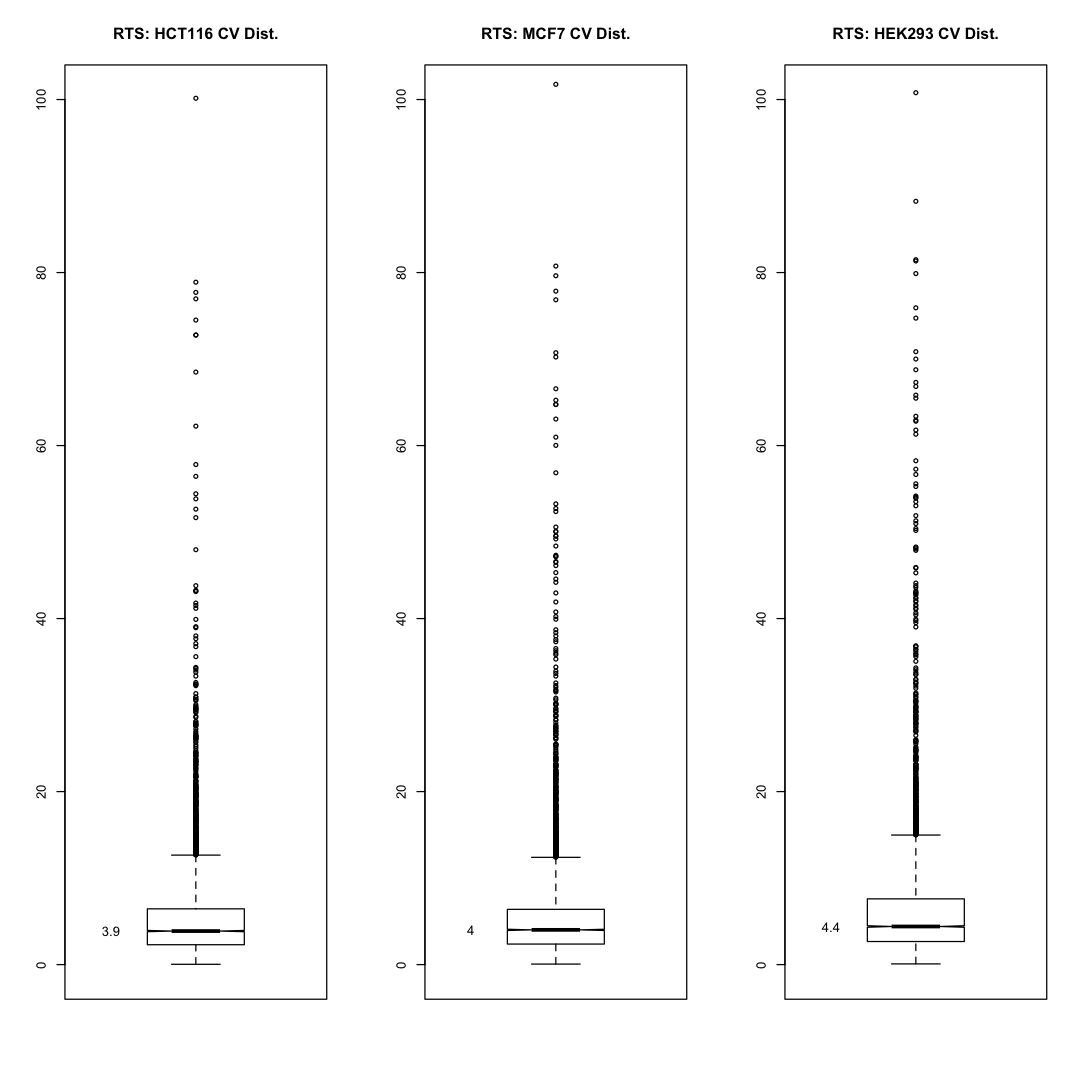

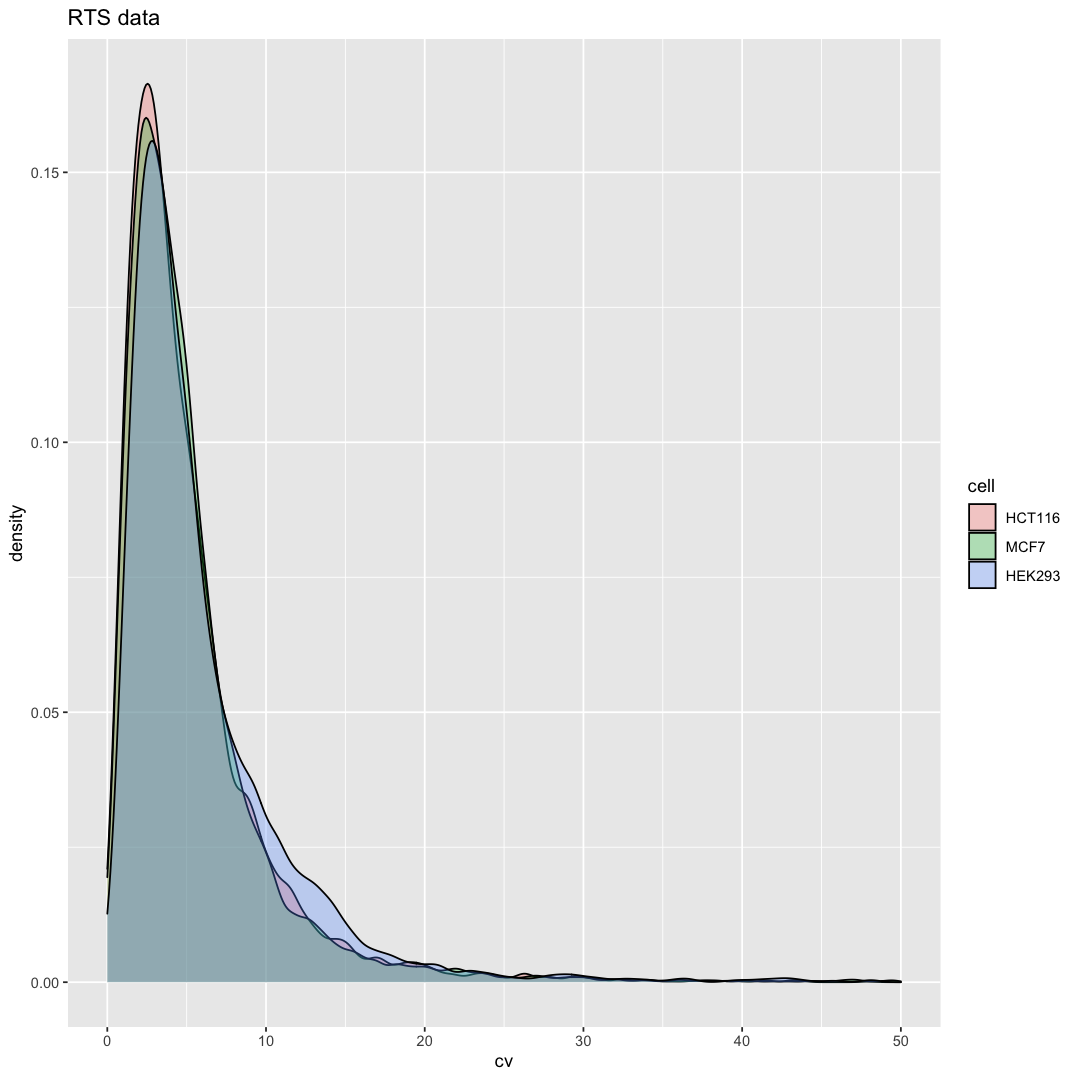

In [14]:
# get the RTS data from the SLNorm data
data_sl_rts <- data_sl[reg]

# print out some CV values
CV_tmt <- data.frame(HCT = CV(data_sl_rts[HCT]), MCF = CV(data_sl_rts[MCF]), 
                  HEK = CV(data_sl_rts[HEK]))
medians <- apply(CV_tmt, 2, FUN = median)
print("TMT CVs (%)")
round(medians, 2)

# labeled boxplots
par(mfrow = c(1, 3))
labeled_boxplot(data_sl_rts[HCT], 100, "RTS: HCT116 CV Dist.")
labeled_boxplot(data_sl_rts[MCF], 100, "RTS: MCF7 CV Dist.")
labeled_boxplot(data_sl_rts[HEK], 100, "RTS: HEK293 CV Dist.")
par(mfrow = c(1, 1))

# CV density plot
cv_long <- rbind(data.frame(cv = CV(data_sl_rts[HCT]), cell = "HCT116"),
                data.frame(cv = CV(data_sl_rts[MCF]), cell = "MCF7"),
                data.frame(cv = CV(data_sl_rts[HEK]), cell = "HEK293"))
ggplot(cv_long, aes(x=cv, fill=cell)) +
  geom_density(alpha=0.3) +
  xlim(0, 50) +
  ggtitle("RTS data")

### Median CVs are higher for the RTS data

The median CVs are very small with either acquisition mode. The CVs are a little worse with the RTS data. This is probably due to reduced averaging from the protein close-out choice. The RTS acquisition mode with protein close-out seems to have little adverse effects on the data compared to the regular SPS MS3 mode. The RTS data had a few more identified proteins with similar data quality metrics in half the instrument time. 

I would add some caution here. The protein close-out feature does change the measured data a great deal compared to the regular method. Is the difference unbiased? Two acquisition methods were compared - regular SPS MS3 and real time search SPS MS3. However, the LC times were also changed. Furthermore, the protein close-out feature is confounded with the change in LC time. More data would have to be collected to tease out the effects of each of these changes.

The second RTS paper still seems proof of principle in nature rather than a more thorough evaluation of RTS. There are several things being put forth in the Schweppe et al. paper. There is a monoisotopic mass correction algorithm. There is use of mostly full-featured Comet instead a binomial scoring, there is an on the fly FDR filtering algorithm, and there is the protein close-out feature to improve sampling depth. The relative merits and/or contributions of each algorithm would be nice to know.

---

# Log session and end

In [15]:
# log the session details
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.15.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] janitor_2.0.1   psych_1.9.12.31 edgeR_3.24.3    limma_3.38.3   
 [5] scales_1.1.0    forcats_0.5.0   stringr_1.4.0   dplyr_0.8.5    
 [9] purrr_0.3.3     readr_1.3.1     tidyr_1.0.2     tibble_2.1.3   
[13] ggplot2_3.3.0   tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4       locfit_1.5-9.1   lubridate_1.7.4  lattice_0.20-40 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.5  reprex_0.3.0  